In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import torch
import torch.optim
import torch.nn as nn

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark =False
dtype = torch.cuda.FloatTensor

PLOT = False
imsize = -1
dim_div_by = 64

from scipy.io import loadmat,savemat
from PIL import Image

import math

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import v2

from curvelops import FDCT2D
from curvelops.plot import create_colorbar

import cv2

# Dataset BSDS500

In [2]:
transformator = v2.Compose([
    v2.Grayscale(),
    v2.ToTensor(),
    v2.Resize(size=(256,256),antialias=True)
])

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [3]:
## load BSD dataset
! wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
! tar -xf BSR_bsds500.tgz
! mv BSR/BSDS500/ ./
! rm -rf BSR/

--2023-11-06 04:41:08--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8000::1, 2620:12a:8001::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2023-11-06 04:41:08--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2023-11-06 04:41:08--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (ww

In [4]:
from torchvision.io.image import ImageReadMode
class BSDTrainDataset(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir = root_dir
        self.filelist = os.listdir(root_dir)
        self.transform = transform

    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.filelist[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)
        image = torch.unsqueeze(image,0)
        return image

In [5]:
A = BSDTrainDataset(root_dir='BSDS500/data/images/train',
                    transform = transformator)

# Mask Train

In [6]:
from re import X
 # network
def convfunc(in_channel,out_channel,kernel_size=3):
    """
        Encoder with one simple layer (ReflectionPad, Conv2D, BN, AF)
    """
    padsize = kernel_size//2
    conv_instance = nn.Sequential(
        nn.Conv2d(in_channel,out_channel,kernel_size,padding=padsize,stride=1,padding_mode='reflect'),
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(out_channel,out_channel,kernel_size,padding=padsize,stride=1,padding_mode='reflect'),
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2, inplace=True),
    )


    return conv_instance

def maxpoolfunc(kernel_size=3):
    padsize = kernel_size//2
    stridesize = kernel_size-1
    return nn.MaxPool2d(kernel_size,stride=stridesize,padding=padsize)

def upsamplefunc(in_channel,out_channel,kernel_size=3):
    stridesize = kernel_size-1
    conv_func = nn.ConvTranspose2d(in_channel,out_channel,kernel_size,stride=stridesize,padding=1,output_padding=1)
    return conv_func


class myUNET(nn.Module):
    def __init__(self,depth=2,num_channels=[10,20,40,80,160],encoder_kernel_size=3,decoder_kernel_size=3,imgsz = 512,tailfunc=None):
        super(myUNET,self).__init__()

        self.depth = depth;
        self.encoderlist = nn.ModuleList()

        # encoder
        self.encoderlist.append(convfunc(1,num_channels[0],kernel_size=encoder_kernel_size))
        self.encoderlist.append(maxpoolfunc(encoder_kernel_size))
        for i in range(1,depth):
            self.encoderlist.append(convfunc(num_channels[i-1],num_channels[i],kernel_size=encoder_kernel_size))
            if i != (depth-1): # no max pool at the end
              self.encoderlist.append(maxpoolfunc(encoder_kernel_size))


        # self.bottom = convfunc(num_channels[depth-1],num_channels[depth-1],kernel_size=encoder_kernel_size)

        # decoder
        self.decoderlist = nn.ModuleList()
        for i in range(depth-1,0,-1):
            self.decoderlist.append(upsamplefunc(num_channels[i],num_channels[i-1],decoder_kernel_size))
            self.decoderlist.append(convfunc(num_channels[i],num_channels[i-1],kernel_size=decoder_kernel_size))

        # self.decoderlist.append(upsamplefunc(num_channels[0],num_channels[0],decoder_kernel_size))
        self.decoderlist.append(convfunc(num_channels[0],1,kernel_size=decoder_kernel_size))


        self.tail = tailfunc

    def forward(self,x):
        skipval = list()
        y = x
        for i in range(self.depth*2-1):
            layer = self.encoderlist[i]
            # print(y.shape)
            y = layer(y)
            # print(y.shape)
            if(i%2==0):
                # print("Add Skip")
                skipval.append(y)

        skipval.pop()
        # print("Going up")
        for i in range((self.depth-1)*2):
            layer = self.decoderlist[i]
            # print(y.shape)
            y = layer(y)
            # print(y.shape)
            if(i%2==0):
                # print("concat")
                A = skipval.pop()
                # print(A.shape)
                y = torch.cat([A,y],dim=1) # stack
        # last layer conv
        layer = self.decoderlist[-1]
        y = layer(y)

        y = self.tail(y)
        # print(y.shape)

        return y




def get_noise(input_depth,spatial_size,var=0.1):
    shape = [1, input_depth, spatial_size[0], spatial_size[1]]
    net_input = torch.zeros(shape)

    net_input.uniform_()
    net_input *= var

    return net_input

def np_to_torch(x):
    return torch.from_numpy(x)[None,:]

def torch_to_np(x):
    return x.detach().cpu().numpy()[0]

In [7]:
UNETinstance = myUNET(depth=5,encoder_kernel_size = 3,decoder_kernel_size=3,imgsz = 256,tailfunc = nn.ReLU())

# Interpolation

In [8]:
from scipy.interpolate import griddata

def create_mask(rate,sz):
    a = np.zeros(sz**2, dtype=int)
    nonzeromask = round(rate*sz**2)
    a[:nonzeromask] = 1
    np.random.shuffle(a)
    a = np.reshape(a,(sz,sz))
    a = torch.from_numpy(a)
    return a


def interpolation(iminput,a,method='nearest'):
    #iminput = torch.squeeze(A[0])

    #a = np.zeros(iminput.shape[0]**2, dtype=int)
    #nonzeromask = 10000
    #a[:nonzeromask] = 1
    #np.random.shuffle(a)
    #a = np.reshape(a,(iminput.shape[0],iminput.shape[1]))
    #a = torch.from_numpy(a)

    idx = torch.nonzero(a)

    grid_x, grid_y = np.meshgrid(np.arange(0,iminput.shape[0]),np.arange(0,iminput.shape[1]), indexing='ij')
    val = torch.zeros(a.type(torch.int).sum().item())
    for j,i in enumerate(idx):
        val[j] = iminput[i[0]][i[1]]


    grid_z0 = griddata(idx, val, (grid_x, grid_y), method='nearest')

    grid_z0 = torch.from_numpy(grid_z0)
    grid_z0 = torch.unsqueeze(grid_z0,0)
    grid_z0 = torch.unsqueeze(grid_z0,0)
    return grid_z0


def cv2_inpainting(A,mask,method=cv2.INPAINT_TELEA):
    # convert to rgb
    A = cv2.cvtColor((A*mask)*255,cv2.COLOR_GRAY2BGR).astype('uint8')
    mask2 = ((1-mask)*255).astype('uint8')

    rec = cv2.inpaint(A,mask2,3,method)

    gray = cv2.cvtColor(rec, cv2.COLOR_BGR2GRAY)

    gray = gray / gray.max()

    gray = torch.from_numpy(gray)
    gray = torch.unsqueeze(gray,0)
    gray = torch.unsqueeze(gray,0)
    return gray

# CS-CVT solver

In [9]:
def geo_mean(iterable):
    return np.exp(np.log(iterable).mean())
        
# ALL CVT COMPUTATION
def softh_complex(C, gamma=-1):
    args = np.arctan2(np.imag(C),np.real(C))
    abss = np.abs(C)
    if(gamma == -1):
        gamma = geo_mean(abss)
    maxA = abss - gamma
    maxA = maxA * (maxA > 0)
    softh = np.exp(1j*args)*maxA
    return softh

def softh_cvt(X,C,gamma=-1):
    outp = np.real(C.H @ softh_complex(C @ X,gamma=-1))
    normr = np.linalg.norm(C @ outp,1)
    return outp,normr

# ALL DCT COMPUTATION
def dct2(block):
    from scipy.fftpack import dct
    return dct(dct(block.T, norm='ortho').T, norm='ortho')
    
def idct2(block):
    from scipy.fftpack import idct
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def softh_real(coeff,gamma=-1):
    if(gamma == -1):
        gamma = geo_mean(np.abs(coeff.flatten()))
    maxA = abs(coeff) - gamma
    maxA = maxA * (maxA > 0)
    softh = np.sign(coeff)*maxA
    return softh

def softh_dct(X,gamma=-1):
    outp = idct2(softh_real(dct2(X),gamma=-1))
    normr = np.linalg.norm(dct2(outp),1)
    return outp,normr

# ALL TV COMPUTATION
def tv(X,thTV = 0.01):
    sz = X.shape[0]
    phi1 = np.zeros((sz,sz))
    phi1[-1,-1] = 1
    phi1[1:,0:-1] = np.eye(sz-1)
    
    phi2 = np.zeros((sz,sz))
    phi2[-1,-1] = 1
    phi2[0:-1,1:] = np.eye(sz-1)
    
    th_ = X@(np.eye(sz) -phi1 - phi1.T + phi1@phi1.T)
    tv_ = (np.eye(sz) -phi2 - phi1.T + phi1.T@phi1)@X
    
    outp = X - thTV*(th_ + tv_)

    th_ = outp@(np.eye(sz) -phi1 - phi1.T + phi1@phi1.T)
    tv_ = (np.eye(sz) -phi2 - phi1.T + phi1.T@phi1)@outp
    normr = np.linalg.norm((th_ + tv_),'fro')
    return outp,normr

# compute residual
def residual(Y,X,M):
    T = M * X
    r = (Y - T)
    outp = X + r
    return outp

def CS_CVT(Y,X,M,ITER_MAX=10,**kwargs):
    iternow = 0
    CVT_coeff = FDCT2D(
        X.shape,
        allcurvelets=True)

    itercond = iternow < ITER_MAX
    while itercond:
        # soft-threshold CVT
        step1,p1 = softh_cvt(X,CVT_coeff)
        
        # soft threshold DCT
        step2,p2 = softh_dct(step1)
        
        # TV
        step3,p3 = tv(step2)
        
        # residual
        X = residual(Y,step3,M)

        # show evaluation
        if 'GROUND_TRUTH' in kwargs:
            eval = np.linalg.norm(X-kwargs['GROUND_TRUTH'],'fro');
            # print(eval)
        else:
            evalnow = p1+p2+p3 
            if(iternow == 0):
                evalbef = evalnow
            grad = np.abs(evalnow - evalbef) / evalbef
            evalbef = evalnow
            # print(grad)
        
        iternow = iternow + 1
        
        itercond = iternow < ITER_MAX
    return step1


# Training with Interpolation

# Training with CS-CVT + NN

tensor(0.2536)


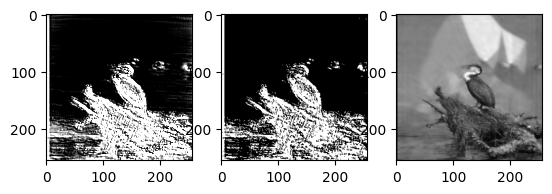

tensor(0.2385)


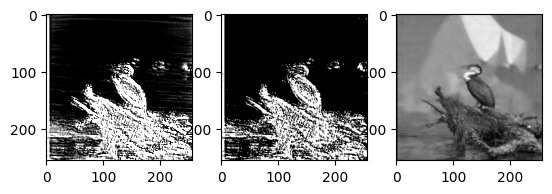

tensor(0.2221)


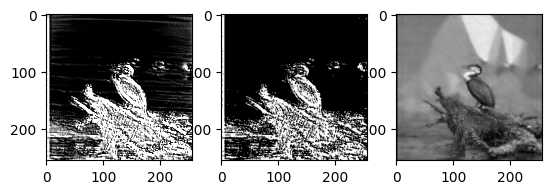

tensor(0.2041)


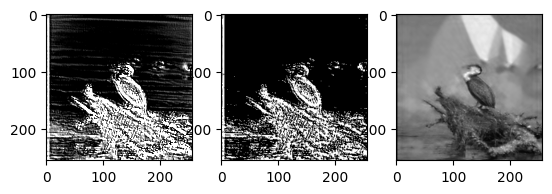

tensor(0.1853)


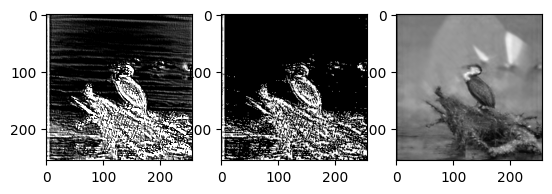

tensor(0.1664)


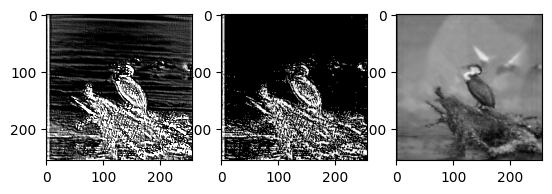

tensor(0.1480)


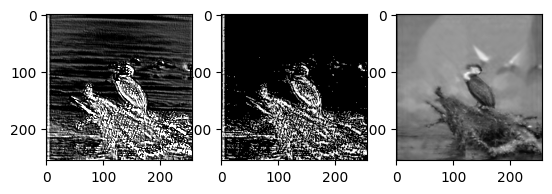

tensor(0.1339)


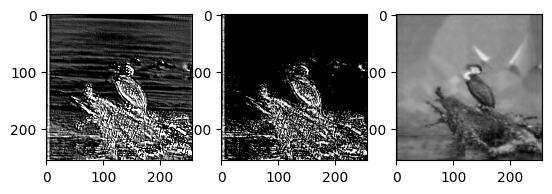

tensor(0.1223)


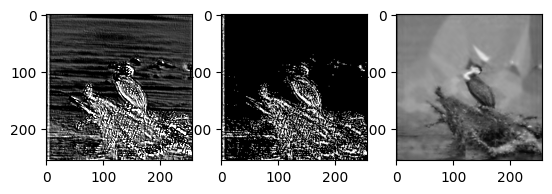

tensor(0.1140)


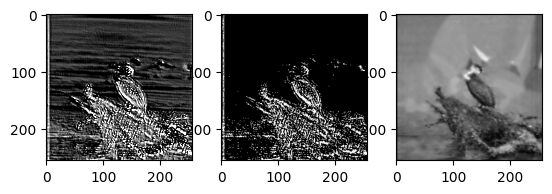

tensor(0.1090)


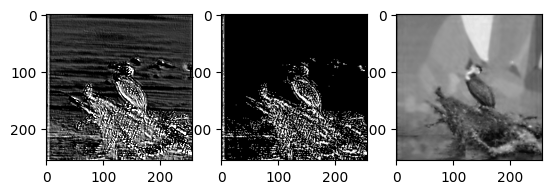

tensor(0.1071)


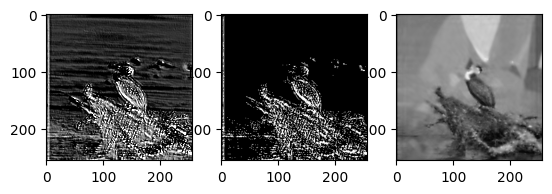

tensor(0.1073)


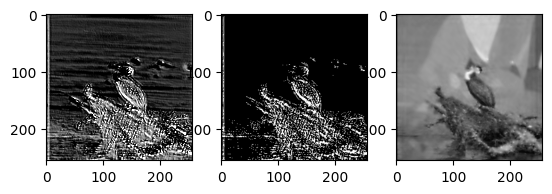

tensor(0.1093)


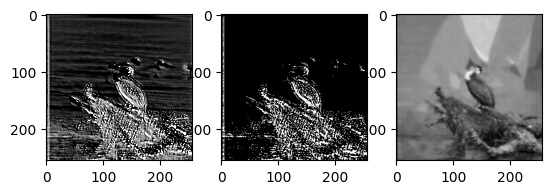

tensor(0.1125)


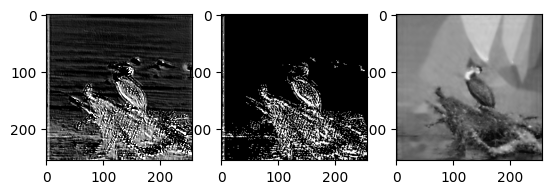

tensor(0.1166)


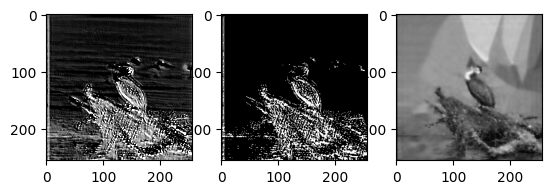

tensor(0.1199)


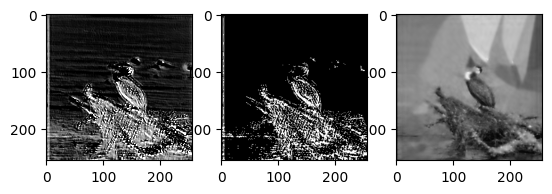

tensor(0.1206)


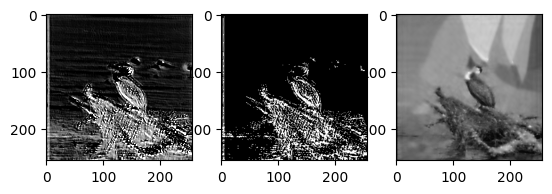

In [ ]:
UNETinstance = myUNET(depth=2,encoder_kernel_size = 3,decoder_kernel_size=3,imgsz = 256,tailfunc = nn.ReLU())
UNEToptimizer = torch.optim.Adam([x for x in UNETinstance.parameters()], lr=1e-4)
inpimg = A[0]

pctg = 1.0
iterNum = 0
MAX_ITER = 500
while(pctg > 0.05) and (iterNum < MAX_ITER):
    iterNum = iterNum + 1
    UNEToptimizer.zero_grad()
    OutMask = UNETinstance(inpimg)

    ProperMask = (OutMask.data > 0.6).type(torch.float32)

    # OutInpainting = interpolation(torch.squeeze(inpimg),torch.squeeze(ProperMask),method='cubic')
    Y = torch.squeeze(inpimg)
    M = torch.squeeze(ProperMask)
    # X = torch.squeeze(interpolation(Y,M,method='nearest'))
    X = torch.squeeze(cv2_inpainting((M*Y).numpy(),M.numpy(),method=cv2.INPAINT_NS))
    RECON = CS_CVT((M*Y).numpy(),X.numpy(),M.numpy(),MAX_ITER = 200)
    RECON = torch.unsqueeze(torch.from_numpy(RECON),dim=0)
    OutInpainting = torch.unsqueeze(RECON,dim=0)
    
    mse = torch.nn.MSELoss()
    l1loss = torch.nn.L1Loss()

    # loss = mse(OutInpainting,inpimg) + 1e-5*l1loss(OutMask,torch.zeros(OutMask.shape))
    loss = mse(OutInpainting,inpimg) + l1loss(OutMask,torch.zeros(OutMask.shape))
    loss.backward()
    UNEToptimizer.step()

    pctg = ProperMask.mean().item()

    if iterNum%2 == 0:
        print(ProperMask.mean())
        plt.subplot(1,3,1)
        plt.imshow(torch.squeeze(OutMask.data),cmap='gray',vmin=0,vmax=1)
        plt.subplot(1,3,2)
        plt.imshow(torch.squeeze(ProperMask),cmap='gray',vmin=0,vmax=1)
        plt.subplot(1,3,3)
        plt.imshow(torch.squeeze(OutInpainting.data),cmap='gray',vmin=0,vmax=1)
        plt.show()